## Setup

In [3]:
#Here we're defining the scope of the countries for our analysis.
#Because we're working with multiple datasets many countries have different names for the same region, so we're listing all the subregions and alternative names for the the target country.
#We've made each key for the scope of the country the countries ISO code due to standardization and ease of mapping the country.
countryScope = {
    "COL": ["Colombia", "Colombia (Medellin)"],
    "IRQ": ["Iraq"],
    "PER": ["Peru"],
    "CHN": ["PRC China", "China"],
    "UKR": ["Ukraine"],
    "BRA": ["Brazil"],
    "BGR": ["Bulgaria"],
    "MEX": ["Mexico"],
    "ROU": ["Romania"],
    "ZAF": ["South Africa"],
    "AUS": ["Australia"],
    "BEL": ["Belgium"],
    "DEU": ["Germany", "German Federal Republic"],
    "ISR": ["Israel"],
    "ITA": ["Italy"],
    "JPN": ["Japan"],
    "NZL": ["New Zealand"],
    "GBR": ["United Kingdom", "Northern Ireland"],
    "PRT": ["Portugal"],
    "ESP": ["Spain", "Spain (Murcia)"],
    "NLD": ["The Netherlands", "Netherlands"],
    "USA": ["The USA", "USA", "United States of America"]
}
#Here we're creating a function to standardize the names of our countries and regions to the target countries ISO code.
#The function is referencing the countryScope dictionary allowing us to normalize the country name for merges.

def standardizeCountryNames(df, country_col, country_scope):
    #Creating an empty dictionary who's key is the country name, and who's value is the corresponding ISO code.
    standardized_countries = {}
    # This loops through each key-value pair in the country_scope dictionary. iso_code is the key (the ISO country code), and names is the value (a list of country names).
    for iso_code, names in country_scope.items():
        for name in names:
            standardized_countries[name] = iso_code
    #This maps the country names in the specified column of the DataFrame to their corresponding ISO codes using the standardized_countries dictionary.
    #The .fillna() method in this this case ensures that any country name not found in the countryScope remains unchanged.
    df[country_col] = df[country_col].map(standardized_countries).fillna(df[country_col])
    return df

In [4]:
#Data imports
hiefData = pd.read_csv(r'..\data\hiefData.csv', comment='#')
usVeteransFKBP5 = pd.read_csv(r'..\data\usVeteransFKBP5.csv', comment='#')
ptsdWorldMentalHealthSurvey = pd.read_csv(r'..\data\ptsdWorldMentalHealthSurvey.csv', comment='#')
healthCarePriceIndex = pd.read_csv(r'..\data\healthCarePriceIndex.csv', comment='#')

### Lifetime Prevalence Of PTSD Compared To Trauma Exposure And The Cost Of Healthcare.

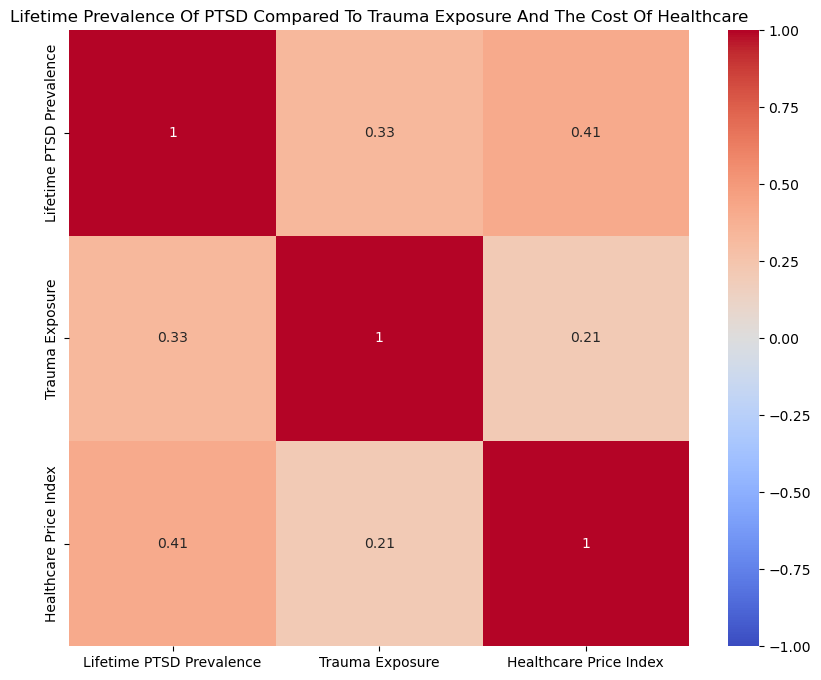

In [5]:
#Here we're standardizing the country names for the two relevant datasets we need for this particular analysis.
ptsdWorldMentalHealthSurvey = standardizeCountryNames(ptsdWorldMentalHealthSurvey, 'Country', countryScope)
healthCarePriceIndex = standardizeCountryNames(healthCarePriceIndex, 'Country', countryScope)
#Merging healthcare price index with PTSD and trauma exposure data.
ptsdAndHealthCare = ptsdWorldMentalHealthSurvey.merge(healthCarePriceIndex[['Country', 'Healthcare price index world average = 100']], on='Country', how='inner')
#Verify that the merged DataFrame is not empty.
if not ptsdAndHealthCare.empty:
    #Creating DataFrame set to the prevalence of PTSD, trauma exposure, and healthcare price index
    ptsdAgainstTraumaAndHealthCare = ptsdAndHealthCare[['Lifetime prevalence of PTSD in total sample (%)', 'Trauma exposure (%)', 'Healthcare price index world average = 100']]
    ptsdAgainstTraumaAndHealthCareCopy = ptsdAgainstTraumaAndHealthCare.copy()
    #Renaming columns for correlation matrix due to large size of column names.
    ptsdAgainstTraumaAndHealthCareCopy.rename(
        columns={
            'Lifetime prevalence of PTSD in total sample (%)': 'Lifetime PTSD Prevalence',
            'Trauma exposure (%)': 'Trauma Exposure',
            'Healthcare price index world average = 100': 'Healthcare Price Index'
        },
        inplace=True
    )
    #Creating correlation DataFrame.
    ptsdAgainstTraumaAndHealthCareCorrMatrix = ptsdAgainstTraumaAndHealthCareCopy.corr()
    #Creating subplot for heatmap.
    plt.figure(figsize=(10,8))
    #Generating heatmap of correlation matrix, and normalizing variable scale to be on point 0 +/- 1.
    sns.heatmap(ptsdAgainstTraumaAndHealthCareCorrMatrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Lifetime Prevalence Of PTSD Compared To Trauma Exposure And The Cost Of Healthcare")
    plt.xticks(rotation=0)
    plt.yticks(rotation=90) 
    #Displaying generated heatmap.
    plt.show()


#-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-#

#Creating a duplicate DataFrame in order not to mutate the original dataset, plus its just good practice.
ptsdWorldMentalHealthSurveyCopy = ptsdWorldMentalHealthSurvey.copy()
#Here we're categorizing the trauma and PTSD columns with the .cut() method into 2 distinct categories, comprised of 3 separate bins, with each bin being given a unique label.
#The float('inf') is a standard to represent infinity for the IEEE.
ptsdWorldMentalHealthSurveyCopy['traumaCategory'] = pd.cut(ptsdWorldMentalHealthSurveyCopy['Trauma exposure (%)'], bins=[-1, 55, 70, float('inf')], labels=['Low Trauma', 'Moderate Trauma', 'High Trauma']).astype(str)
ptsdWorldMentalHealthSurveyCopy['PTSDCategory'] = pd.cut(ptsdWorldMentalHealthSurveyCopy['Lifetime prevalence of PTSD in total sample (%)'], bins=[-1, 2.7, 5.3, float('inf')], labels=['Low PTSD', 'Moderate PTSD', 'High PTSD']).astype(str)
#Creates a new column that holds the value of the combined categories for each country.
#I've included the .fillna() method because for some reason the .cut() method seems to be creating NaN values when concatenating despite there not being any missing values within the CSV.
ptsdWorldMentalHealthSurveyCopy['combinedCategory'] = ptsdWorldMentalHealthSurveyCopy['traumaCategory'].fillna('') + '-' + ptsdWorldMentalHealthSurveyCopy['PTSDCategory'].fillna('')
# Defining color for map for each combined category.
traumaToPTSDColorMap = {
    'Low Trauma-Low PTSD': '#1b8a5a',
    'Low Trauma-Moderate PTSD': '#9ACD32',
    'Low Trauma-High PTSD': '#FFD700',
    'Moderate Trauma-Low PTSD': '#1d4877',
    'Moderate Trauma-Moderate PTSD': '#ffd73e',
    'Moderate Trauma-High PTSD': '#FF8C00',
    'High Trauma-Low PTSD': '#f68838',
    'High Trauma-Moderate PTSD': '#ee3e32',
    'High Trauma-High PTSD': '#b40426'
}
ptsdWorldMentalHealthSurveyCopy['Country Code'] = ptsdWorldMentalHealthSurveyCopy['Country']
#Creates a new column in the same DataFrame as above, holding the respective color of the country in reference to the color map dictionary.
#The .map() method is used to replace the values in our Series based on a dictionary.
ptsdWorldMentalHealthSurveyCopy['Color'] = ptsdWorldMentalHealthSurveyCopy['combinedCategory'].map(traumaToPTSDColorMap)
# Here we are finally creating the choropleth map.
ptsdToTraumaMap = px.choropleth(
    ptsdWorldMentalHealthSurveyCopy,
    locations="Country Code",
    color="combinedCategory",
    hover_name="Country",
    hover_data=[
        "Lifetime prevalence of PTSD in total sample (%)", "Trauma exposure (%)"
    ],
    color_discrete_map=traumaToPTSDColorMap,
    category_orders={
        "combinedCategory": [
            'Low Trauma-Low PTSD', 'Low Trauma-Moderate PTSD', 'Low Trauma-High PTSD',
            'Moderate Trauma-Low PTSD', 'Moderate Trauma-Moderate PTSD', 'Moderate Trauma-High PTSD',
            'High Trauma-Low PTSD', 'High Trauma-Moderate PTSD', 'High Trauma-High PTSD'
        ]
    },
    title="Lifetime PTSD Prevalence & Trauma Exposure by Country"
)
#Update the geographic layout using update_geos, since we can't seem to use geos within the choropleth itself.
ptsdToTraumaMap.update_geos(
    showframe=True,
    showcoastlines=True,
    projection_type='orthographic'
)
ptsdToTraumaMap.show()

### Lifetime Prevalence Of PTSD Compared To The Historical Index of Ethnic Fractionalization.

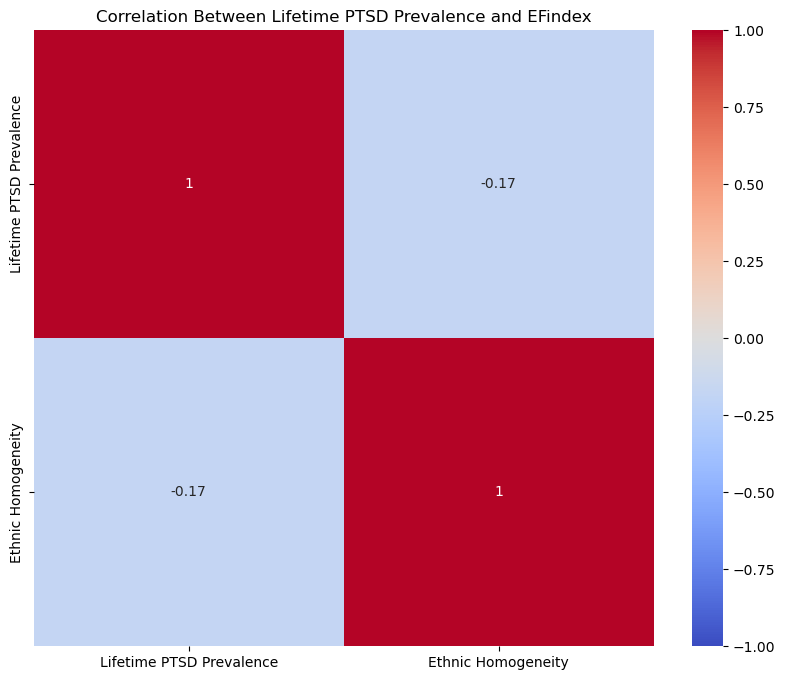

In [6]:
#Renames the 'Country Name' column so that we can pass it through the standardization pipeline.
hiefData.rename(columns={'Country Name': 'Country'}, inplace=True)
#Standardize country names in hiefData.
hiefDataCopy = standardizeCountryNames(hiefData.copy(), 'Country', countryScope)
#Calculate the average EFindex for each country.
avgHief = hiefDataCopy.groupby('Country')['EFindex'].mean().reset_index()
#Standardize country names in ptsdWorldMentalHealthSurvey.
ptsdWorldMentalHealthSurveyCopy = standardizeCountryNames(ptsdWorldMentalHealthSurvey.copy(), 'Country', countryScope)
#Merge the PTSD data with the average EFindex data.
mergedHiefData = pd.merge(ptsdWorldMentalHealthSurveyCopy[['Country', 'Lifetime prevalence of PTSD in total sample (%)']], avgHief, on='Country')
#Renaming columns for correlation matrix due to large size of column names.
mergedHiefData.rename(
    columns={
        'Lifetime prevalence of PTSD in total sample (%)': 'Lifetime PTSD Prevalence',
        'EFindex': 'Ethnic Homogeneity'
    }, 
    inplace=True
)
#Creating correlation DataFrame.
ptsdToEFindexCorrMatrix = mergedHiefData[['Lifetime PTSD Prevalence', 'Ethnic Homogeneity']].corr()
# Creating subplot for heatmap
plt.figure(figsize=(10, 8))
# Generating heatmap of correlation matrix, and normalizing variable scale to be on point 0 +/- 1.
sns.heatmap(ptsdToEFindexCorrMatrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(rotation=0)
plt.yticks(rotation=90) 
#Displaying generated heatmap.
plt.title('Correlation Between Lifetime PTSD Prevalence and EFindex')
plt.show()

#-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-##-#

#Merging our two datasets.
mentalHealthAndHiefComparisonData = pd.merge(ptsdWorldMentalHealthSurveyCopy, avgHief, on='Country')
#Creating category thresholds for out individual datasets.
mentalHealthAndHiefComparisonData['EFindexCategory'] = pd.cut(mentalHealthAndHiefComparisonData['EFindex'], bins=[-1, 0.3, 0.6, float('inf')], labels=['High Homogeneity', 'Moderate Homogeneity', 'Low Homogeneity']).astype(str)
mentalHealthAndHiefComparisonData['PTSDCategory'] = pd.cut(mentalHealthAndHiefComparisonData['Lifetime prevalence of PTSD in total sample (%)'], bins=[-1, 2.7, 5.3, float('inf')], labels=['Low PTSD', 'Moderate PTSD', 'High PTSD']).astype(str)
#Create combined categories for each country.
mentalHealthAndHiefComparisonData['combinedCategory'] = mentalHealthAndHiefComparisonData['EFindexCategory'].fillna('') + '-' + mentalHealthAndHiefComparisonData['PTSDCategory'].fillna('')
#Define color map for combined categories.
efToPTSDColorMap = {
    'High Homogeneity-Low PTSD': '#1b8a5a',
    'High Homogeneity-Moderate PTSD': '#9ACD32',
    'High Homogeneity-High PTSD': '#FFD700',
    'Moderate Homogeneity-Low PTSD': '#1d4877',
    'Moderate Homogeneity-Moderate PTSD': '#ffd73e',
    'Moderate Homogeneity-High PTSD': '#FF8C00',
    'Low Homogeneity-Low PTSD': '#f68838',
    'Low Homogeneity-Moderate PTSD': '#ee3e32',
    'Low Homogeneity-High PTSD': '#FF0000'
}
#Add color column based on the combined category.
mentalHealthAndHiefComparisonData['Color'] = mentalHealthAndHiefComparisonData['combinedCategory'].map(efToPTSDColorMap)
#Create a choropleth map.
efToPTSDMap = px.choropleth(
    mentalHealthAndHiefComparisonData,
    locations="Country",
    locationmode='ISO-3',
    color="combinedCategory",
    hover_name="Country",
    hover_data=[
        "EFindex", "Lifetime prevalence of PTSD in total sample (%)"
    ],
    color_discrete_map=efToPTSDColorMap,
    category_orders={
        "combinedCategory": [
            'High Homogeneity-Low PTSD', 'High Homogeneity-Moderate PTSD', 'High Homogeneity-High PTSD',
            'Moderate Homogeneity-Low PTSD', 'Moderate Homogeneity-Moderate PTSD', 'Moderate Homogeneity-High PTSD',
            'Low Homogeneity-Low PTSD', 'Low Homogeneity-Moderate PTSD', 'Low Homogeneity-High PTSD'
        ]
    },
    title="Ethnic Fractionalization Index & PTSD Prevalence by Country"
)
#Update the geographic layout using update_geos.
efToPTSDMap.update_geos(
    showframe=True,
    showcoastlines=True,
    projection_type='orthographic'
)
efToPTSDMap.show()

### Single Nucleotide Polymorphisms Frequency By Ethnic Group Compared To The Historical Index of Ethnic Fractionalization, Lifetime Prevalence Of PTSD, and Trauma Exposure.

In [7]:
#Here we use regular expression (regex) extraction (.str.extract()) to extract the numeric values within the parentheses within each respective SNP columns.
#Then we convert the extracted strings into float types.
#Lastly we create new columns for each respective SNP combination.
usVeteransFKBP5['Frequency 1:1'] = usVeteransFKBP5['1:1'].str.extract(r'\((\d+\.\d+)\)').astype(float)
usVeteransFKBP5['Frequency 1:2'] = usVeteransFKBP5['1:2'].str.extract(r'\((\d+\.\d+)\)').astype(float)
usVeteransFKBP5['Frequency 2:2'] = usVeteransFKBP5['2:2'].str.extract(r'\((\d+\.\d+)\)').astype(float)
#Next we add detailed labels for each genotype, creating new columns with these labels.
usVeteransFKBP5['SNP_1:1'] = usVeteransFKBP5['SNP'] + ' 1:1'
usVeteransFKBP5['SNP_1:2'] = usVeteransFKBP5['SNP'] + ' 1:2'
usVeteransFKBP5['SNP_2:2'] = usVeteransFKBP5['SNP'] + ' 2:2'
#At this point we've essentially duplicated the previous columns, however now it's much cleaning and simpler to reshape for plotting.
#We now have 3 new columns with all the SNP types, the frequencies for those SNP's and the group associated with the SNP.
reshapedData11 = usVeteransFKBP5[['SNP_1:1', 'Frequency 1:1', 'Group']].rename(columns={'SNP_1:1': 'SNP_Genotype', 'Frequency 1:1': 'Frequency'})
reshapedData12 = usVeteransFKBP5[['SNP_1:2', 'Frequency 1:2', 'Group']].rename(columns={'SNP_1:2': 'SNP_Genotype', 'Frequency 1:2': 'Frequency'})
reshapedData22 = usVeteransFKBP5[['SNP_2:2', 'Frequency 2:2', 'Group']].rename(columns={'SNP_2:2': 'SNP_Genotype', 'Frequency 2:2': 'Frequency'})
#Here we're combining the data to tell the program to treat this information as a single dataset for plotting.
reshapedSNPData = pd.concat([reshapedData11, reshapedData12, reshapedData22])
#Now we can generate a scatter plot using Plotly.
fig = px.scatter(reshapedSNPData, x='SNP_Genotype', y='Frequency', color='Group',
                 title='Genotype Frequencies in Control and PTSD Groups',
                 labels={'SNP_Genotype': 'SNP and Genotype',
                         'Frequency': 'Frequency'},
                 symbol='Group', size_max=10)
#Update layout for better aesthetics.
fig.update_layout(
    title_font_size=24,
    xaxis_title_font_size=18,
    yaxis_title_font_size=18,
    legend_title_font_size=16,
    legend_font_size=14,
    xaxis_tickangle=-90,
    xaxis_tickfont_size=12,
    yaxis_tickfont_size=14,
    width=1200,
    height=800,
    margin=dict(l=40, r=40, t=80, b=40)
)
#Show the plot.
fig.show()